In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
class MyDataset(Dataset):

    def __init__(self, dataset):
        super(MyDataset, self).__init__()
        self.dataset = dataset

    def __getitem__(self, idx):
        return self.dataset.data[idx].reshape(-1, 1, 28, 28), self.dataset.targets[idx]

    def __len__(self):
        return len(self.dataset)

网络

In [3]:
def vgg_block(in_channels, out_channels, num_convs):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU()]

    for _ in range(num_convs - 1):
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1))
        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))

    return nn.Sequential(*layers) # *layers 加个*是解包,将list中的数据依次拿出来

In [4]:
def try_gpu():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [5]:
vgg_size = [(1, 4, 1), (4, 8, 2)]

def vgg(p1 = 0.0, p2 = 0.0):

    vgg_blocks = []

    for in_channels, out_channels, num_convs in vgg_size:
        vgg_blocks.append(vgg_block(in_channels, out_channels, num_convs))

    net = nn.Sequential(
        *vgg_blocks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 128), nn.ReLU(), nn.Dropout(p1),
        nn.Linear(128, 128), nn.ReLU(), nn.Dropout(p2),
        nn.Linear(128, 10)
    )

    return net

In [6]:
def get_net(p1 = 0.0, p2 = 0.0):
    return vgg(p1, p2)

In [7]:
def init_parms(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

数据

In [8]:
image_to_tensor = transforms.ToTensor()

In [9]:
train_dataset = torchvision.datasets.FashionMNIST('data', train = True, transform = image_to_tensor, download = True)
test_dataset = torchvision.datasets.FashionMNIST('data', train = False, transform = image_to_tensor, download = True)

训练及测试

In [10]:
def num_accuracy(y_hat, y):

    predict = torch.argmax(y_hat, dim = 1)
    count = (predict == y).float().sum().item()

    return count

In [11]:
def train(net, train_iter, test_iter, lr, num_epochs, is_cross_validate):

    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr = lr)

    if not is_cross_validate:
        epoch_train_loss_list = []
        epoch_train_acc_list = []
        epoch_test_acc_list = []
        epoch_list = []

    for epoch in range(num_epochs):

        train_loss_metric = d2l.Accumulator(2)
        train_acc_metric = d2l.Accumulator(2)
        test_acc_metric = d2l.Accumulator(2)

        for x, y in train_iter:

            net.train()

            x = x.to(try_gpu())
            y = y.to(try_gpu())

            updater.zero_grad()
            y_hat = net(x)
            l = loss(y_hat, y)
            l.sum().backward()
            updater.step()

            with torch.no_grad():
                train_loss_metric.add(l, l.numel())
                train_acc_metric.add(num_accuracy(y_hat, y), y.numel())

        epoch_train_loss = train_loss_metric[0] / train_loss_metric[1]
        epoch_train_acc = train_acc_metric[0] / train_acc_metric[1]

        for x, y in test_iter:

            net.eval()

            x = x.to(try_gpu())
            y = y.to(try_gpu())

            with torch.no_grad():
                y_hat = net(x)

                test_acc_metric.add(num_accuracy(y_hat, y), y.numel())

        epoch_test_acc = test_acc_metric[0] / test_acc_metric[1]

        if not is_cross_validate:
            epoch_train_loss_list.append(epoch_train_loss)
            epoch_train_acc_list.append(epoch_train_acc)
            epoch_test_acc_list.append(epoch_test_acc)
            epoch_list.append(epoch + 1)

    if not is_cross_validate:
        plt.plot(epoch_list, epoch_train_loss_list, label = 'train_loss')
        plt.plot(epoch_list, epoch_train_acc_list, label = 'train_acc')
        plt.plot(epoch_list, epoch_test_acc_list, label = 'test_acc')
        plt.legend()
        plt.show()

    return epoch_train_loss, epoch_train_acc, epoch_test_acc


In [12]:
batch_size = 128

train_iter = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_iter = DataLoader(test_dataset, batch_size = batch_size)

In [13]:
lr, num_epochs = 0.05, 10

In [14]:
def get_k_fold_data(k, i, train_data):

    assert k > 1

    fold_size = len(train_data) // k

    my_data = MyDataset(train_data)
    cross_train_x, cross_train_y = None, None
    cross_validate_x, cross_validate_y = None, None

    for j in range(k):

        idx = slice(j * fold_size, (j + 1) * fold_size)
        x_part, y_part = my_data[idx]
        if j == i:
            cross_validate_x, cross_validate_y = x_part, y_part
        elif cross_train_x is None:
            cross_train_x, cross_train_y = x_part, y_part
        else:
            cross_train_x = torch.cat([cross_train_x, x_part], dim = 0)
            cross_train_y = torch.cat([cross_train_y, y_part], dim = 0)

    cross_train_x = torch.as_tensor(cross_train_x, dtype = torch.float32)
    cross_validate_x = torch.as_tensor(cross_validate_x, dtype = torch.float32)
    
    cross_train_x = (cross_train_x - torch.mean(cross_train_x)) / torch.std(cross_train_x)
    cross_validate_x = (cross_validate_x - torch.mean(cross_validate_x)) / torch.std(cross_validate_x)

    return cross_train_x, cross_train_y, cross_validate_x, cross_validate_y

In [15]:
def k_fold_cross_validate(net, k, train_dataset):

    cross_train_loss, cross_train_acc, cross_validate_acc = 0.0, 0.0, 0.0

    for i in range(k):

        cross_train_x, cross_train_y, cross_validate_x, cross_validate_y = get_k_fold_data(k, i, train_dataset)

        cross_train_iter = d2l.load_array((cross_train_x, cross_train_y), batch_size = batch_size, is_train = True)
        cross_validate_iter = d2l.load_array((cross_validate_x, cross_validate_y), batch_size = batch_size)
        
        net.apply(init_parms)

        part_train_loss, part_train_acc, part_validate_acc = train(net, cross_train_iter, cross_validate_iter, lr, num_epochs,is_cross_validate = True)

        cross_train_loss += part_train_loss
        cross_train_acc += part_train_acc
        cross_validate_acc += part_validate_acc

    train_loss = cross_train_loss / k
    train_acc = cross_train_acc / k
    validate_acc = cross_validate_acc / k

    return train_loss, train_acc, validate_acc

In [16]:
ps = [0.1, 0.5, 0.9]
p_1, p_2 = 0.0, 0.0
max_validate_acc = 0.0

for p1 in ps:
    for p2 in ps:

        net = get_net(p1, p2)
        net.to(try_gpu())

        train_loss, train_acc, validate_acc = k_fold_cross_validate(net, 5, train_dataset)
        print('p1:',p1,'p2:',p2)
        print('train_acc:',train_acc)
        print('validate_acc:',validate_acc)

        if validate_acc > max_validate_acc:
            p_1 = p1
            p_2 = p2
            max_validate_acc = validate_acc

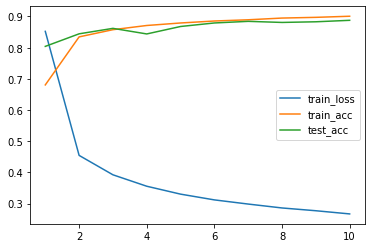

p1: 0.0 p2: 0.0
train_loss: 0.26678333464843124
train_acc: 0.9007666666666667
test_acc: 0.8877


In [17]:
net = get_net(p_1, p_2)
net.apply(init_parms)
net.to(try_gpu())

train_loss, train_acc, test_acc = train(net, train_iter, test_iter, lr = lr, num_epochs = num_epochs, is_cross_validate = False)
print('p1:', p_1, 'p2:', p_2)
print('train_loss:', train_loss)
print('train_acc:', train_acc)
print('test_acc:', test_acc)